In [25]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, kurtosis, skew, chi2
from numpy.linalg import cholesky

In [26]:
# Get market data
tickers = ['TSLA', 'AAPL', 'FB', 'NVDA', 'MSFT', 'AMZN']
start = (dt.datetime.now() - relativedelta(years=5)).strftime('%Y-%m-%d')
df = yf.download(tickers,start)['Adj Close']

[*********************100%***********************]  6 of 6 completed


In [27]:
# Define weights & estimate returns
weights = np.random.rand(len(tickers)) # random weights
weights /= np.sum(weights) # force total portfolio equal to one
port_ret = np.log(df/df.shift(1)).dropna() # logarithmic returns

#Get financials
ret = port_ret.mean().values
mean = np.dot(weights.T,ret)
cov = port_ret.cov()
std = np.sqrt(
        np.dot(weights.T,np.dot(cov,weights))
)
last_price = np.dot(df.iloc[-1].values,weights.T)

In [28]:
# Historical VaR
x = np.dot(port_ret.values,weights)
VaR_hist = np.percentile(x,1) # 99% of confidence
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_hist*100))

Daily Value at Risk of portfolio is -5.36%


In [29]:
# Parametric VaR
confidence_level = norm.ppf(0.99) # 99% percentile of a standard normal distribution
time_delta = 1
VaR_param = mean - (confidence_level * std * np.sqrt(time_delta))
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_param*100))

Daily Value at Risk of portfolio is -4.30%


In [30]:
# Jarque Bera test
size = len(port_ret)
x = np.dot(port_ret.values,weights) # total returns of portfolio
kurt = kurtosis(x) # excess kurtosis (kurtosis - 3)
skewness = skew(x) #skewness
mean = np.mean(x)
jb = size/6*(skewness**2 + 1/4*kurt**2)
p_value = 1 - chi2.cdf(jb, df=2) 
is_normal = (p_value > 0.05)
print(
    'Jarque Bera test results' + '\n'\
    + '\nStatistical: ' + str(np.round(jb,4))+ '\n'\
    + 'Kurtosis:    ' + str(np.round(kurt+3,4)) + '\n'\
    + 'Skewness:    ' + str(np.round(skewness,4)) + '\n'\
    + 'P-Value:     ' + str(np.round(p_value,4))+ '\n'\
    + 'Is normal:   ' + str(is_normal)
)

Jarque Bera test results

Statistical: 2400.6172
Kurtosis:    9.5815
Skewness:    -0.7878
P-Value:     0.0
Is normal:   False


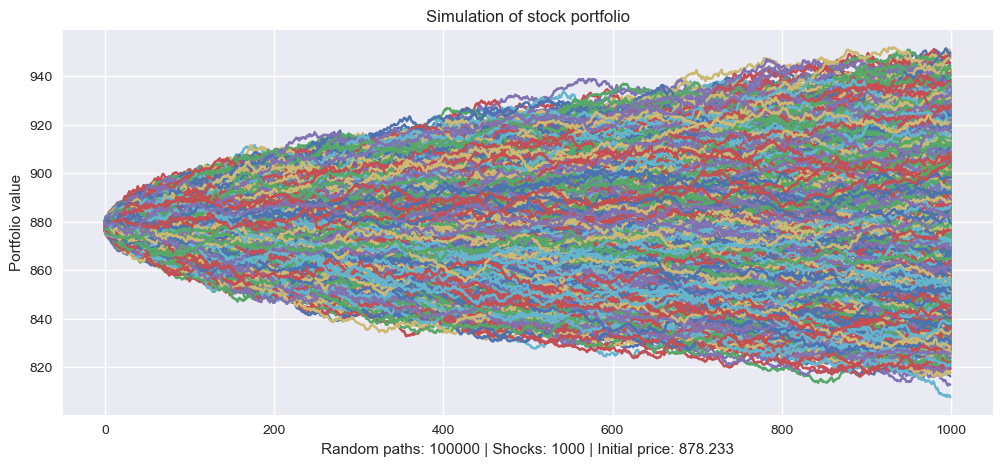

In [31]:
# Monte-Carlo simulation
simulations = 100000
T = 1000
mean_mtx = np.full(shape=(T, len(weights)), fill_value=ret/T).T
portf_simulations = np.full(shape=(T, simulations),fill_value=0.0)
initial_portf = last_price

for i in range(0, simulations):
     Z = np.random.normal(size=(T, len(weights)))
     L = cholesky(cov/T)
     daily_ret = mean_mtx + np.inner(L,Z)
     portf_simulations[:,i] = np.cumprod(np.inner(weights,daily_ret.T)+1)*initial_portf

plt.figure(figsize=(12,5))
plt.style.use('seaborn')
plt.plot(portf_simulations)
plt.ylabel('Portfolio value')
plt.xlabel(
     'Random paths: ' + str(simulations)+\
     ' | Shocks: ' + str(T) +\
     ' | Initial price: ' + str(np.round(last_price,4))
 )
plt.title('Simulation of stock portfolio')
plt.show()

In [32]:
# VaR by Monte Carlo simulation
#x = np.dot(port_ret.values,weights)
perct = np.percentile(portf_simulations,1) # 99% of confidence
VaR_MC = perct/last_price -1
print('Daily Value at Risk of portfolio is {0:.2f}%'.format(VaR_MC*100))

Daily Value at Risk of portfolio is -3.33%


In [33]:
print(
    'Historical VaR: ' + str(np.round(VaR_hist*100,4)) + '%' + '\n'+\
    'Parametric VaR: ' + str(np.round(VaR_param*100,4)) + '%' + '\n'+\
    'Simulated VaR:  ' + str(np.round(VaR_MC*100,4)) + '%'
)

Historical VaR: -5.359%
Parametric VaR: -4.3002%
Simulated VaR:  -3.3285%
